***Лабораторна робота №1<br>***
*Виконали студенти 3 курсу<br>
групи "Комп'ютерна математика"<br>
Демченко Андрій та Нікіфоров Олександр<br>*


Імпортуємо потрібні бібліотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Глобальні змінні

In [2]:
N_TRAIN = 150
N_TEST = 20

***Пункт№1.***<br>
Завантажуємо дані з файлу в датасет та виводимо дані.
Якщо уважно проаналізувати даний датасет,
можна помітити що параметри датасета є нерівноцінними.

In [3]:
dataset = pd.read_csv('heart_failure_clinical_records_dataset.csv')
titles = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
          'ejection_fraction', 'high_blood_pressure', 'platelets',
          'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
print(dataset.head())

# FEATURE_NAMES = ['age', 'anaemia', 'high_blood_pressure', 'serum_sodium', 'sex', 'smoking']
FEATURE_NAMES = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
                 'serum_creatinine', 'serum_sodium', 'time']
size = len(FEATURE_NAMES)

x_df = np.array(dataset[FEATURE_NAMES]).reshape((299, size))
y_df = np.asarray(dataset['DEATH_EVENT'])

xy_shuffled = np.c_[x_df, y_df]
np.random.shuffle(xy_shuffled)

x_shuffled, y_shuffled = xy_shuffled[:, :size], xy_shuffled[:, size:]


    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

***Пункт№3.***<br>
Оптимізатор Momentum.<br>

In [4]:
class Momentum:
    def __init__(self, num_features=1, l_rate=0.01):
        self.m = np.zeros((num_features, 1))
        self.l_rate = l_rate

    def optimize_weights(self, weights, grads):
        self.m = (1 - self.l_rate) * self.m + self.l_rate * grads
        new_weights = weights - self.m

        return new_weights

***Пункт№2.***<br>
Логістична регресія з регуляризацією L1.<br>

In [5]:
class L1:
    def __init__(self, num_features=1, alpha=0.1):
        self.weights = np.zeros((num_features, 1))
        self.optimizer = Momentum(num_features)
        self.epsilon = 0.001
        self.alpha = alpha

    def predict(self, X):
        y = 1 / (1 + np.exp(- (X @ self.weights)))
        return y

    def predict_proba(self, X):
        y = self.predict(X)
        return np.where(y >= 0.5, 1, 0)

    @staticmethod
    def loss_norm( arr):
        res = np.inf
        if len(arr) > 2:
            res = np.abs(np.mean(arr) - np.mean(arr[:-1]))
        return res

    @staticmethod
    def batch_split(X, Y, size):
        features = np.c_[X, Y]
        np.random.shuffle(features)
        features = np.array(np.split(features, range(size, features.shape[0], size)))
        return features

    def fit_batches(self, X, y_true, size=32, epochs=10000, epsilon=0.0001):
        epoch_num = 0
        losses = []
        reg_losses = []
        while (epoch_num < epochs) and (self.loss_norm(losses) > epsilon):
            epoch_num += 1
            current_losses = []
            current_reg_losses = []
            mini_batches = self.batch_split(X, y_true, size)
            for batch in mini_batches:
                x_small, y_small = batch[:, :-1], batch[:, -1].reshape(-1, 1)
                loss, grads, reg_loss = self.one_step_opt(x_small, y_small)
                current_losses.append(loss)
                current_reg_losses.append(reg_loss)
            losses.append(np.mean(current_losses))
            reg_losses.append(np.mean(current_reg_losses))
        return np.array(losses), np.array(reg_losses)

    def one_step_opt(self, X, y_true):
        grad_reg = self.alpha * np.sign(self.weights)
        grad_reg[0, 0] = 0
        reg_loss = np.sum(self.alpha * np.abs(self.weights)) ###
        grads = - X.T @ (y_true - X @ self.weights) / X.shape[0] + grad_reg ###
        self.weights = self.optimizer.optimize_weights(self.weights, grads)

        loss = np.sum((y_true - self.predict(X)).T @ (y_true - self.predict(X))) / X.shape[0]
        return loss, grads, reg_loss

    def fit(self, x_train, y_train, epochs=10000, epsilon=0.00001):
        losses = []
        epoch_num = 0
        while (epoch_num < epochs) and (self.loss_norm(losses) > epsilon):
            epoch_num += 1
            t_loss, grads, reg_loss = self.one_step_opt(x_train, y_train)

            losses.append(t_loss)

        return losses

    def fit_and_check(self, x_train, y_train, x_valid, y_valid, epochs=10000, epsilon=0.00001):
        losses = []
        valid_losses = []
        reg_losses = []
        epoch_num = 0
        while (epoch_num < epochs) and (self.loss_norm(losses) > epsilon):
            epoch_num += 1
            t_loss, grads, reg_loss = self.one_step_opt(x_train, y_train)
            pr=self.predict(x_valid)
            losses.append(t_loss)
            reg_losses.append(reg_loss)
            v_loss = np.sum(-y_valid * np.log(pr + self.epsilon) - (1 - y_valid) * np.log(1 - pr + self.epsilon)) / x_valid.shape[0]
            valid_losses.append(v_loss)
        y_true = self.predict_proba(x_valid)
        accuracy = np.sum(np.where(y_valid == y_true, 1, 0)) / y_valid.shape[0]
        y_t = self.predict(x_valid)
        return losses, valid_losses, reg_losses, accuracy


***Пункт№5.***<br>
Вчимо побудовану модель з параметром регуляризації 0 (без регуляризації) і переконуємось, що вона коректно навчилась.<br>
***Пункт№6.***<br>
Нормалізація данних min-max. Побудування моделі з пункта №5. Порівняння швидкостей. Графіки втрат по ітераціям.<br>

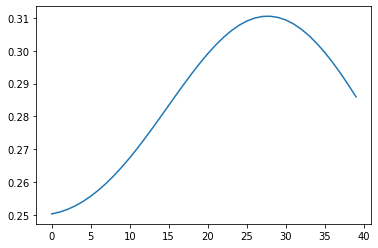

In [6]:
def normalize(X):
    min_f = np.amin(X, axis=0)
    max_f = np.amax(X, axis=0)
    result = (X - min_f) / (max_f - min_f)
    return result

x = normalize(x_shuffled)
y = y_shuffled[:]

x_train, y_train, = x[:N_TRAIN], y[:N_TRAIN].reshape(N_TRAIN, 1)
x_test, y_test = x[N_TRAIN:N_TRAIN + N_TEST], y[N_TRAIN:N_TRAIN + N_TEST].reshape(N_TEST, 1)

model = L1(num_features=size, alpha=0)
losses = model.fit(x_train, y_train)
plt.plot(losses)
plt.show()



***Пункт№4.***<br>
Реалізуємо mini-batch навчання з розміром батча B=32.<br>

<ipython-input-5-b5c0928d2924>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  features = np.array(np.split(features, range(size, features.shape[0], size)))


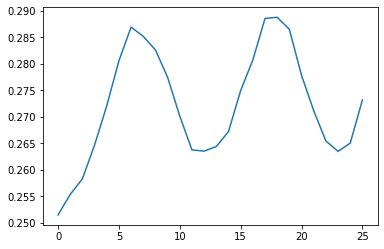

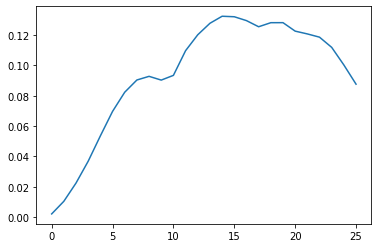

In [7]:
BATCH_SIZE = 32
model = L1(num_features=size, alpha=0.1)
losses, reg_losses = model.fit_batches(x_train, y_train, size=BATCH_SIZE)

plt.figure(1)
plt.plot(losses)
plt.figure(2)
plt.plot(reg_losses)
plt.show()


***Пункт№7.***<br>
Реалізація оцінки точності за допомогою метода кросс-валідації з K=5 фолдами, без регуляризації.

In [8]:
#TODO

***Пункт№8.***<br>
Побудова залежності ваг регресії від коефіцієнтів регуляризації.<br>
***Пункт№9.***<br>
Побудова залежності точності від коефіцієнтів регуляризації.<br>

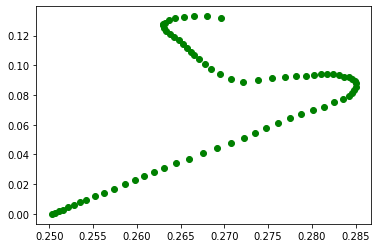

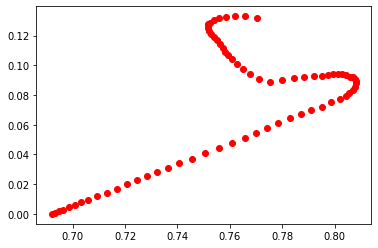

In [9]:
model = L1(num_features=size, alpha=0.1)
losses, valid_losses, reg_losses, accuracy = model.fit_and_check(x_train, y_train, x_test, y_test)

plt.figure(1)
plt.plot(np.array(losses), np.array(reg_losses), "og")
plt.figure(2)
plt.plot(np.array(valid_losses), np.array(reg_losses), "or")
plt.show()


***Пункт№10.***<br>
Покращення

In [10]:
# TODO


***Пункт№11.***<br>
Висновки:
Під час виконання цієї лабораторної роботи,
ми вивчили логістичну регресію L1,
оптимізатор Momentum та нормалізацію min-max,
зрозуміли що таке Underfir и Overfit,
переконалися що регуляризація L1 може зануляти параметри
та сильно зменшувати параметри моделі.
Також ми зрозуміли, що для вдалого машинного навчання,
не слід використовувати всі данні датасету, бо вони мають різний вплив на результат.
